# Horizon to JSON

In [4]:
import numpy as np

In [5]:
ls data

E-38.las        F3_horizon.txt  seismic.h5


In [6]:
raw = np.loadtxt('data/F3_horizon.txt')

In [7]:
raw.shape

(36481, 3)

In [8]:
nulls = np.amax(raw)
np.place(raw, raw==nulls, np.nan)

In [9]:
ilinit, ilfin = np.amin(raw[:,0]), np.amax(raw[:,0])
xlinit, xlfin = np.amin(raw[:,1]), np.amax(raw[:,1])
nIL, nXL = ilfin-ilinit+1, xlfin-xlinit+1

print("inline range {} to {} ({} inlines)".format( ilinit, ilfin, ilfin - ilinit + 1))
print("xline range {} to {} ({} xlines)".format(xlinit, xlfin, xlfin - xlinit + 1))

inline range 310.0 to 500.0 (191.0 inlines)
xline range 310.0 to 500.0 (191.0 xlines)


In [10]:
z = np.empty((nIL, nXL))
#amp = np.empty_like(z)
#sim = np.empty_like(z)

for i, row in enumerate(raw):
    il = row[0] - ilinit
    xl = row[1] - xlinit
    zi = row[2]
#    ai = row[3]
#    si = sim_raw[i][3]
    
    z[il, xl] = zi
#    amp[il, xl] = ai
#    sim[il, xl] = si

/Users/matt/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':
/Users/matt/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [11]:
z.shape

(191, 191)

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

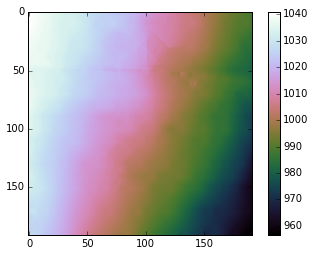

In [17]:
plt.imshow(z, cmap="cubehelix")
plt.colorbar()
plt.show()

In [11]:
z

array([[ 1041.08464718,  1040.96233845,  1040.83991051, ...,
          988.84689808,   988.57647181,   988.28023672],
       [ 1041.07832909,  1040.94958305,  1040.7756567 , ...,
          988.85476589,   988.56496811,   988.24298382],
       [           nan,  1040.91143608,  1040.72463512, ...,
          988.87133598,   988.56216669,   988.22718859],
       ..., 
       [ 1025.58124065,  1026.02481842,  1026.3184309 , ...,
          957.2879076 ,   957.000494  ,   956.65061474],
       [ 1025.4406929 ,  1026.42214298,  1026.74090862, ...,
          957.1596384 ,   956.94088936,   956.63458109],
       [ 1025.40230751,  1027.65572071,  1027.52387524, ...,
          957.06582069,   956.98422194,   956.74568415]])

In [12]:
np.amax(z)

nan

In [13]:
data = {'metadata': {},
        'z': {},
        'geometry': {}
       }

In [14]:
import uuid

In [15]:
line = z[50,:]

data['name'] = 'FS4'
data['location'] = 'Netherlands'
data['survey'] = 'F3'
data['type'] = 'interpretation'
data['interpreter'] = 'unknown'
data['formation'] = 'unknown'
data['age'] = 'unknown'
data['company'] = 'unknown'
data['uuid'] = str(uuid.uuid1())

data['metadata']['dim'] = line.ndim
data['metadata']['shape'] = line.shape
data['metadata']['min'] = np.amin(line)
data['metadata']['max'] = np.amax(line)
data['metadata']['global_min'] = np.amin(z)
data['metadata']['global_max'] = np.amax(z)

data['z']['units'] = 'ms'
data['z']['domain'] = 'time'

data['geometry']['inline_min'] = 50  # Can read these from original datafile,
data['geometry']['inline_max'] = 50  # but now just have to know them.
data['geometry']['xline_min'] = 310
data['geometry']['xline_max'] = 500

In [16]:
data['data'] = line.tolist()

In [17]:
import os, json

env = %env

path = os.path.join(env['HOME'], os.sep.join(['Dropbox', 'Public']))
with open(os.path.join(path, 'horizon.json'), 'w') as f:
    f.write(json.dumps(data))

## Control precision

This doesn't work...

In [18]:
from json import encoder
encoder.FLOAT_REPR = lambda o: ("%.12g" % o)

json.dumps(line.tolist())[:500]

'[1035.70830821991, 1035.44855117798, 1035.22038459778, 1035.11261940002, 1035.06827354431, 1035.02380847931, 1034.97314453125, 1034.94143486023, 1034.91616249084, 1034.88445281982, 1034.84010696411, 1034.78932380676, 1034.76405143738, 1034.66260433197, 1034.55483913422, 1034.44707393646, 1034.30771827698, 1034.14285182953, 1033.83231163025, 1033.55979919434, 1033.28728675842, 1033.04636478424, 1032.74214267731, 1032.43160247803, 1032.94503688812, 1032.77385234833, 1032.4569940567, 1032.114744186'

## Deal with NaN

'NaN' is not part of [the JSON specification](http://json.org/). The `json` library bungles `np.nan`, so maybe we can replace with a JSON `null` (which is allowed). 

In [19]:
'NaN' in json.dumps(z.tolist())

True

In [20]:
from json import JSONEncoder
class NanConverter(JSONEncoder):
    def default(self, obj):
        try:
            _ = iter(obj)
        except TypeError:
            if isinstance(obj, float) and np.isnan(obj):
                return "null"
        return JSONEncoder.default(self, obj)

In [21]:
'NaN' in json.dumps(z.tolist(), cls=NanConverter)

True

Doesn't work because there's never a type error. 

Seems this next thing does work, but we end up with a dependency on [`simplejson`](https://pypi.python.org/pypi/simplejson/)

In [22]:
import simplejson
'NaN' in simplejson.dumps(z.tolist(), ignore_nan=True)

False

In [23]:
'null' in simplejson.dumps(z.tolist(), ignore_nan=True)

True

# Complete horizon

We can also send the complete horizon...

In [28]:
data = {'metadata': {},
        'z': {},
        'geometry': {}
       }

In [29]:
line = z[50,:]

data['name'] = 'FS4'
data['location'] = 'Netherlands'
data['survey'] = 'F3'
data['type'] = 'interpretation'
data['interpreter'] = 'unknown'
data['formation'] = 'unknown'
data['age'] = 'unknown'
data['company'] = 'unknown'
data['uuid'] = str(uuid.uuid1())

data['metadata']['dim'] = line.ndim
data['metadata']['shape'] = line.shape
data['metadata']['min'] = np.amin(z)
data['metadata']['max'] = np.amax(z)
data['metadata']['global_min'] = np.amin(z)
data['metadata']['global_max'] = np.amax(z)

data['z']['units'] = 'ms'
data['z']['domain'] = 'time'

data['geometry']['inline_min'] = 310  # Can read these from original datafile,
data['geometry']['inline_max'] = 500  # but now just have to know them.
data['geometry']['xline_min'] = 310
data['geometry']['xline_max'] = 500

In [30]:
data

{'age': 'unknown',
 'company': 'unknown',
 'formation': 'unknown',
 'geometry': {'inline_max': 500,
  'inline_min': 310,
  'xline_max': 500,
  'xline_min': 310},
 'interpreter': 'unknown',
 'location': 'Netherlands',
 'metadata': {'dim': 1,
  'global_max': nan,
  'global_min': nan,
  'max': nan,
  'min': nan,
  'shape': (191,)},
 'name': 'FS4',
 'survey': 'F3',
 'type': 'interpretation',
 'uuid': '47ed3a86-45c4-11e5-8934-a820663a5ca4',
 'z': {'domain': 'time', 'units': 'ms'}}

In [31]:
data['data'] = z.tolist()

In [32]:
with open(os.path.join(path, 'horizon_complete.json'), 'w') as f:
    f.write(json.dumps(data))